In [2]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
threads = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)
    model.cpp.delink()

# Solve and simulate from alternative models

In [4]:
# settings for models to solve
T = 10

# Upper envelope not implmented for EGM yet.
specs = {
    'model 1':{'latexname':'vfi', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'do_egm':False,'threads':threads, 'simT':T, 'beta': 0.95, },},
    'model 2':{'latexname':'egm', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'do_egm':True,'threads':threads,'simT':T, 'beta': 0.95},},
    'model 3':{'latexname':'egm', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'do_egm':True,'threads':threads, 'analytic_single_marg_u':False, 'simT':T, 'beta': 0.95}},
}

In [5]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=do_compile)
    models[name].spec = spec    

    print('linked to cpp')
    # solve
    %time models[name].solve()

    if do_cpp: models[name].cpp.delink()

model = models['model 3']
par = model.par
sol = model.sol

solving model 1...
linked to cpp
CPU times: total: 45.6 s
Wall time: 4.44 s
solving model 2...
linked to cpp
CPU times: total: 1.61 s
Wall time: 611 ms
solving model 3...
linked to cpp
CPU times: total: 1.88 s
Wall time: 668 ms


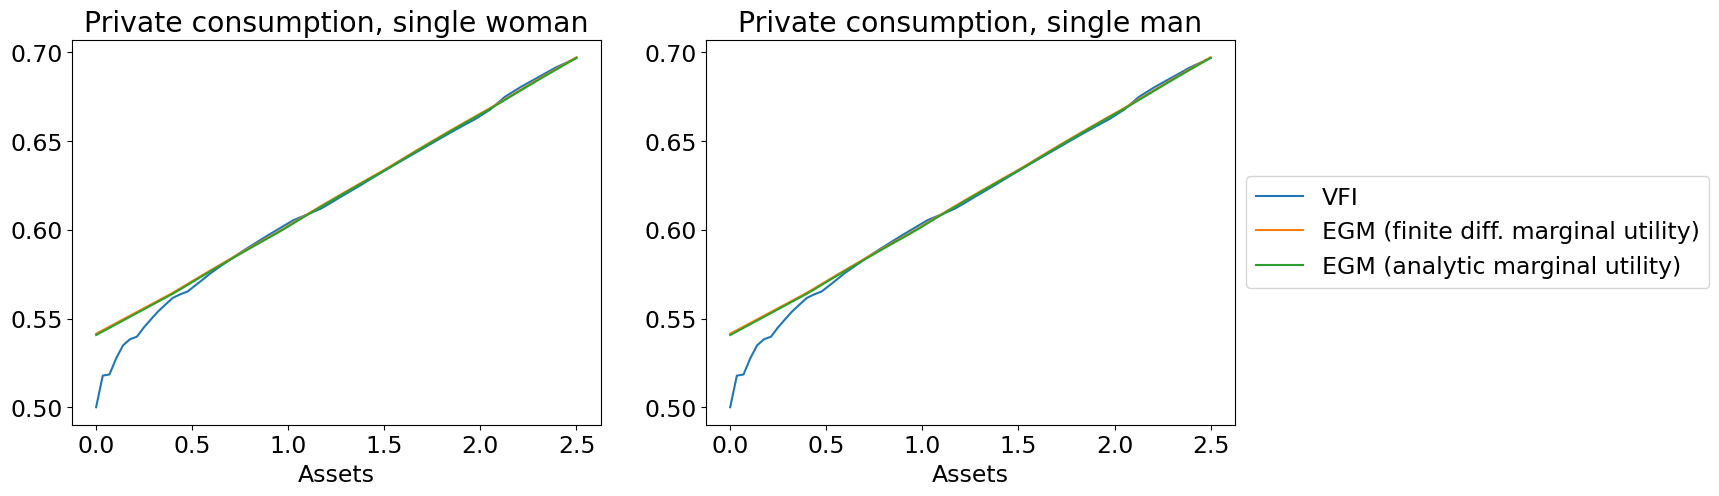

In [7]:
# plot some solutions

# two figures next to each other
fig, axs = plt.subplots(1,2,figsize=(15,5))

t = 0

ax0 = axs[0]
ax0.plot(models['model 1'].par.grid_Aw, models['model 1'].sol.Cw_priv_single[t,:], label='VFI')
ax0.plot(models['model 2'].par.grid_Aw, models['model 2'].sol.Cw_priv_single[t,:], label='EGM (finite diff. marginal utility)')
ax0.plot(models['model 3'].par.grid_Aw, models['model 3'].sol.Cw_priv_single[t,:], label='EGM (analytic marginal utility)')
ax0.set_xlabel('Assets')
ax0.set_title('Private consumption, single woman')


ax1 = axs[1]
ax1.plot(models['model 1'].par.grid_Am, models['model 1'].sol.Cm_priv_single[t,:], label='VFI')
ax1.plot(models['model 2'].par.grid_Am, models['model 2'].sol.Cm_priv_single[t,:], label='EGM (finite diff. marginal utility)')
ax1.plot(models['model 3'].par.grid_Am, models['model 3'].sol.Cm_priv_single[t,:], label='EGM (analytic marginal utility)')
ax1.set_xlabel('Assets')
ax1.set_title('Private consumption, single man')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# so close


# Simulated paths

In [ ]:
# var_list = ('Cw_priv','Cm_priv','Cw_pub','C_tot','A','power','power_idx','love','couple')
# model_list = ('model 1','model 2')

# SAVE = False
# for init_power_idx in (1,10):
#     for init_love in (0.0,0.2): 

#             for i,name in enumerate(model_list):
#                 model = models[name]

#                 # show how starting of in a low bargaining power gradually improves
#                 model.sim.init_power_idx[:] = init_power_idx
#                 model.sim.init_love[:] = init_love 
#                 model.simulate()
                
#             for var in var_list:

#                 fig, ax = plt.subplots()
                
#                 for i,name in enumerate(model_list):
#                     model = models[name]

#                     # pick out couples (if not the share of couples is plotted)
#                     if var == 'couple':
#                         nan = 0.0
#                     else:
#                         I = model.sim.couple<1
#                         nan = np.zeros(I.shape)
#                         nan[I] = np.nan

#                     # pick relevant variable for couples
#                     y = getattr(model.sim,var)        
#                     y = np.nanmean(y + nan,axis=0)

#                     ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
#                     ax.set(xlabel='age',ylabel=f'{var}');

#                 plt.legend()

#                 fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
#                 plt.tight_layout()
#                 if SAVE: plt.savefig(path+fig_name+'.pdf')

: 

# Solution

# Policy functions

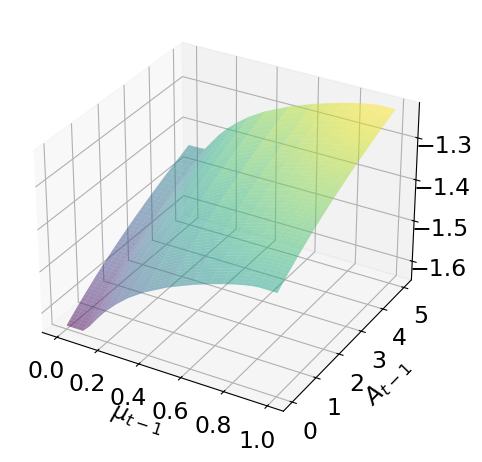

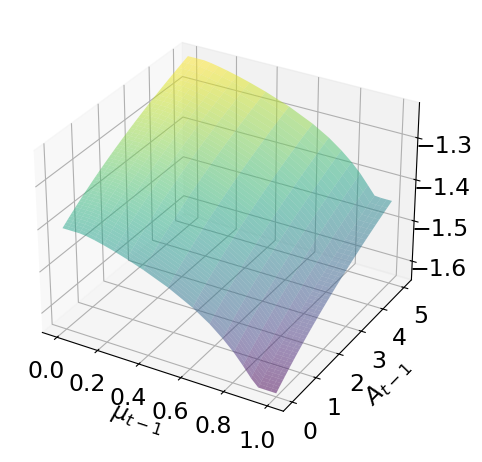

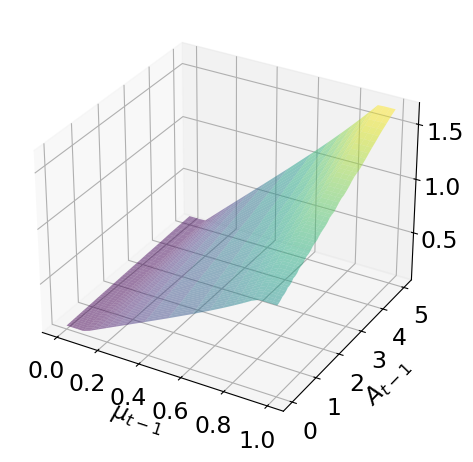

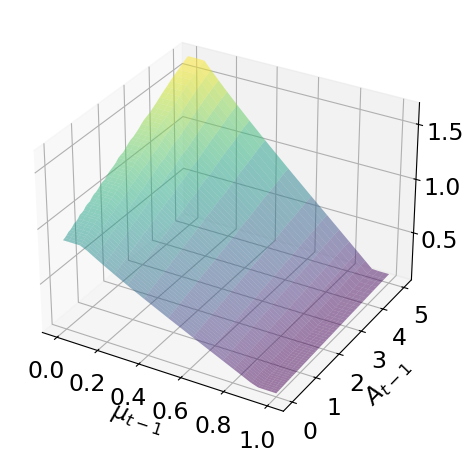

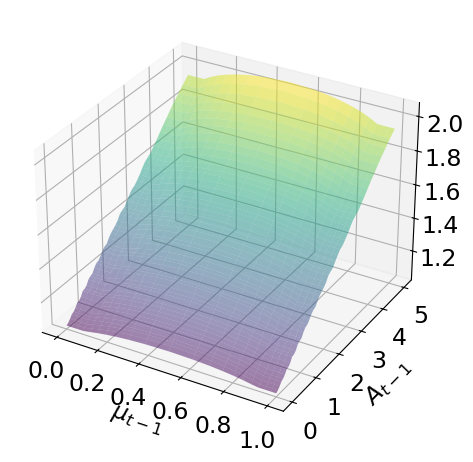

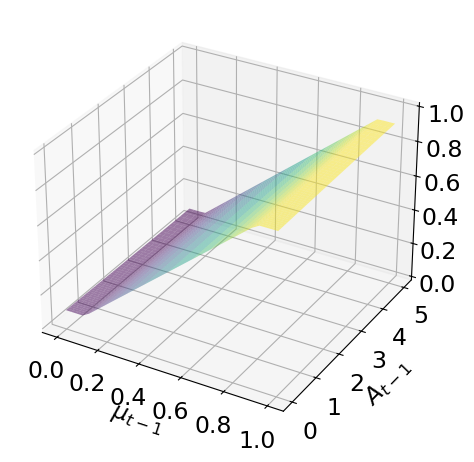

In [8]:
cmaps = ('viridis','gray')
SAVE = False
model_list = ('model 1','model 2')


par = models['model 1'].par
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for iL in (par.num_love//2,): 
    for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        for i,name in enumerate(model_list):
            model = models[name]
            
            t = model.par.T-1-2
        
            Z = getattr(model.sol,var)[t,:,iL,:]
            
            alpha = 0.5 if name=='model 1' else 0.7
            ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
            
            if var == 'power': 
                
                ax.set(zlim=[0.0,1.0])
            
            ax.set(xlabel='$\mu_{t-1}$',ylabel='$A_{t-1}$');
            
        fig_name = f'sol {var} t{t}_love{np.round(par.grid_love[iL]):1.2f}'
        plt.tight_layout()
        if SAVE: plt.savefig(path+fig_name+'.pdf')